In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
TRAIN_DIR = '../input/seg_train/'
TEST_DIR = '../input/seg_test/'

batch_size = 128

model_name = "ResNet34"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

In [5]:
# Data Loader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size, num_workers=2)


In [6]:
# ResNet-18モデルの定義
class CustomResNet34(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet34, self).__init__()
        self.resnet = models.resnet34(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-18モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [7]:
# 2. モデルの構築
model = CustomResNet34(num_classes=6).to(device)


In [8]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [9]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 0.4141405964389854, Val Loss: 0.5764637688795725, Train Acc: 0.8495795924184124, Val Acc: 0.7843333333333333


Epoch 2/50, Train Loss: 0.290159257453516, Val Loss: 0.30455651607674855, Train Acc: 0.8903377511757161, Val Acc: 0.8873333333333333


Epoch 3/50, Train Loss: 0.24244491796974743, Val Loss: 0.751124809399092, Train Acc: 0.9093629756306114, Val Acc: 0.7813333333333333


Epoch 4/50, Train Loss: 0.23647439978811718, Val Loss: 0.46314866448907804, Train Acc: 0.9114293857773977, Val Acc: 0.8376666666666667


Epoch 5/50, Train Loss: 0.20957528827113842, Val Loss: 0.27497341340252507, Train Acc: 0.9216189254667236, Val Acc: 0.9026666666666666


Epoch 6/50, Train Loss: 0.1914486351226448, Val Loss: 0.26302442567733425, Train Acc: 0.9265355565056291, Val Acc: 0.9066666666666666


Epoch 7/50, Train Loss: 0.18988725959981254, Val Loss: 0.30084937061959255, Train Acc: 0.9274618782955679, Val Acc: 0.902


Epoch 8/50, Train Loss: 0.1729566361242478, Val Loss: 0.31574844995824, Train Acc: 0.9331623200798062, Val Acc: 0.898


Epoch 9/50, Train Loss: 0.16140567511320114, Val Loss: 0.33927894073228043, Train Acc: 0.9365113296280462, Val Acc: 0.8843333333333333


Epoch 10/50, Train Loss: 0.14976876522969762, Val Loss: 0.4271482597105205, Train Acc: 0.94043038335471, Val Acc: 0.8603333333333333


Epoch 11/50, Train Loss: 0.1422259850307889, Val Loss: 0.32760997163131833, Train Acc: 0.9432093487245261, Val Acc: 0.891


Epoch 12/50, Train Loss: 0.13648664602719315, Val Loss: 0.3208543402142823, Train Acc: 0.9449194812597976, Val Acc: 0.8843333333333333


Epoch 13/50, Train Loss: 0.12794397183514516, Val Loss: 0.3076867546575765, Train Acc: 0.9488385349864614, Val Acc: 0.8993333333333333


Epoch 14/50, Train Loss: 0.11506034074983465, Val Loss: 0.3345380420796573, Train Acc: 0.9531851218469432, Val Acc: 0.9063333333333333


Epoch 15/50, Train Loss: 0.126695414099398, Val Loss: 0.3140722579555586, Train Acc: 0.9471996579734929, Val Acc: 0.9


Epoch 16/50, Train Loss: 0.10360459745818869, Val Loss: 0.281665400446703, Train Acc: 0.9563203648282742, Val Acc: 0.913


Epoch 17/50, Train Loss: 0.09696548008317248, Val Loss: 0.3560276650338589, Train Acc: 0.960453185121847, Val Acc: 0.8966666666666666


Epoch 18/50, Train Loss: 0.08750658487439703, Val Loss: 0.36640318879896466, Train Acc: 0.9619495510902095, Val Acc: 0.9003333333333333


Epoch 19/50, Train Loss: 0.09334661254505498, Val Loss: 0.37416783297279227, Train Acc: 0.9621633176571184, Val Acc: 0.8843333333333333


Epoch 20/50, Train Loss: 0.07031952235164173, Val Loss: 0.30657673615496606, Train Acc: 0.9681487815305686, Val Acc: 0.914


Epoch 21/50, Train Loss: 0.07301317430485826, Val Loss: 0.32180628230950487, Train Acc: 0.9690751033205074, Val Acc: 0.9096666666666666


Epoch 22/50, Train Loss: 0.07811521326935073, Val Loss: 0.3166661093321939, Train Acc: 0.9672224597406299, Val Acc: 0.9096666666666666


Epoch 23/50, Train Loss: 0.06720027305322503, Val Loss: 0.32638580615942675, Train Acc: 0.9712840245118997, Val Acc: 0.918


Epoch 24/50, Train Loss: 0.06247626085244461, Val Loss: 0.34120112696352106, Train Acc: 0.9719965797349295, Val Acc: 0.9083333333333333


Epoch 25/50, Train Loss: 0.055605384307580254, Val Loss: 0.4524952833210894, Train Acc: 0.9746330340601397, Val Acc: 0.8956666666666667


Epoch 26/50, Train Loss: 0.04978885077401449, Val Loss: 0.4208298822244008, Train Acc: 0.9759868889838963, Val Acc: 0.9023333333333333


Epoch 27/50, Train Loss: 0.06019912746845992, Val Loss: 0.3871901125336687, Train Acc: 0.9724241128687473, Val Acc: 0.898


Epoch 28/50, Train Loss: 0.05514049471928439, Val Loss: 0.3000539348577149, Train Acc: 0.9752743337608665, Val Acc: 0.9143333333333333


Epoch 29/50, Train Loss: 0.04307016957158206, Val Loss: 0.34292420325800776, Train Acc: 0.9788371098760154, Val Acc: 0.918


Epoch 30/50, Train Loss: 0.058347007221277426, Val Loss: 0.3792353435322487, Train Acc: 0.9742055009263217, Val Acc: 0.9006666666666666


Epoch 31/50, Train Loss: 0.04948638188182761, Val Loss: 0.3311340725437428, Train Acc: 0.9765569331623201, Val Acc: 0.915


Epoch 32/50, Train Loss: 0.030915290681183885, Val Loss: 0.43809265612314147, Train Acc: 0.983326207781103, Val Acc: 0.9046666666666666


Epoch 33/50, Train Loss: 0.05436638279587304, Val Loss: 0.36105385054058087, Train Acc: 0.9756306113723814, Val Acc: 0.908


Epoch 34/50, Train Loss: 0.04357733525369966, Val Loss: 0.389124047011137, Train Acc: 0.9791221319652273, Val Acc: 0.9113333333333333


Epoch 35/50, Train Loss: 0.03324673874218256, Val Loss: 0.3804874460911378, Train Acc: 0.9825423970357703, Val Acc: 0.919


Epoch 36/50, Train Loss: 0.04116522010689208, Val Loss: 0.39007338508963585, Train Acc: 0.9787658543537124, Val Acc: 0.9106666666666666


Epoch 37/50, Train Loss: 0.04338040589910308, Val Loss: 0.42156894668005407, Train Acc: 0.9792646430098333, Val Acc: 0.904


Epoch 38/50, Train Loss: 0.03447150121391708, Val Loss: 0.41237452377875644, Train Acc: 0.9831836967364971, Val Acc: 0.9086666666666666


Epoch 39/50, Train Loss: 0.03486283959761057, Val Loss: 0.37530847074231133, Train Acc: 0.9826136525580732, Val Acc: 0.9183333333333333


Epoch 40/50, Train Loss: 0.03440666894872733, Val Loss: 0.3967609354682888, Train Acc: 0.9822573749465584, Val Acc: 0.91


Epoch 41/50, Train Loss: 0.041313118480761114, Val Loss: 0.38794384415571886, Train Acc: 0.9812597976343167, Val Acc: 0.912


Epoch 42/50, Train Loss: 0.029735838951662593, Val Loss: 0.42232773143041413, Train Acc: 0.9847513182271626, Val Acc: 0.9143333333333333


Epoch 43/50, Train Loss: 0.03186044224469555, Val Loss: 0.39210840310018585, Train Acc: 0.9831836967364971, Val Acc: 0.919


Epoch 44/50, Train Loss: 0.029378185150162273, Val Loss: 0.4373254836743096, Train Acc: 0.983753740914921, Val Acc: 0.9056666666666666


Epoch 45/50, Train Loss: 0.025370722043823554, Val Loss: 0.4586217002943158, Train Acc: 0.9853926179278895, Val Acc: 0.915


Epoch 46/50, Train Loss: 0.02494606668334625, Val Loss: 0.4264158255925092, Train Acc: 0.9856776400171013, Val Acc: 0.9133333333333333


Epoch 47/50, Train Loss: 0.03850001703366774, Val Loss: 0.39494900826442364, Train Acc: 0.9803334758443779, Val Acc: 0.9186666666666666


Epoch 48/50, Train Loss: 0.024634540669508962, Val Loss: 0.45720041745031875, Train Acc: 0.9860339176286163, Val Acc: 0.9136666666666666


Epoch 49/50, Train Loss: 0.03579491655846391, Val Loss: 0.42279040766879916, Train Acc: 0.9816160752458315, Val Acc: 0.913


Epoch 50/50, Train Loss: 0.03756947021764797, Val Loss: 0.4441728924090664, Train Acc: 0.9810460310674077, Val Acc: 0.902


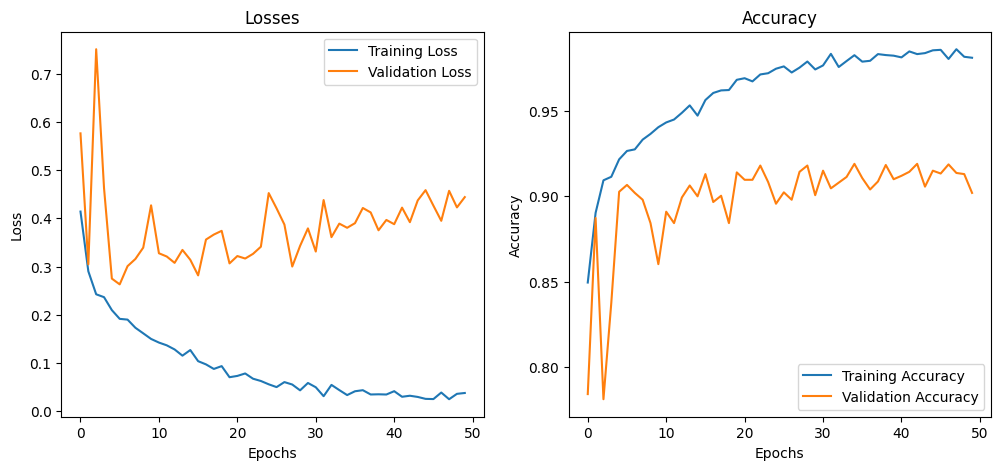

In [11]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
